# Visualize training of Beta VAE on dynamic circle/Gaussian data


### training parameters
- Input: sequences of translating circles on Gaussian-blob background (32x32)

- Number of latents: 10

- batch size: 64

- 50K training samples
- RMSprop w lr = 1e-04

- loss: DKL + reconstruction loss + gamma*prediction loss


Beta VAE:
- six different normalized beta Values (spacing of sampling roughly corresponding to Higgins 2017 y-axis):


``` normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e) ```

``` gamma_values = np.logspace(-4, 4, 5, base=10) ```


In [1]:
import torch
import pickle
from models import dynamicVAE32, beta_from_normalized_beta

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from data.dspritesbT import dSpriteBackgroundDatasetTime

In [2]:
normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e)
gamma_values = np.logspace(-4, 4, 5, base=10)

N = 1 * 32 * 32
M = 10

beta = beta_from_normalized_beta(normalized_beta_values, N = N, M = M)


for ii,nb in enumerate(normalized_beta_values):
    print(['betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii])])
print('gammas: ', gamma_values)

['betanorm = 0.001 / beta = 0.1']
['betanorm = 0.005 / beta = 0.6']
['betanorm = 0.030 / beta = 3.1']
['betanorm = 0.166 / beta = 17.0']
['betanorm = 0.910 / beta = 93.2']
['betanorm = 5.000 / beta = 512.0']
gammas:  [1.e-04 1.e-02 1.e+00 1.e+02 1.e+04]


In [3]:
vae = list()
training_stats = list()

nb = normalized_beta_values.shape[0]
ng = gamma_values.shape[0]

isTrained = [False]*(nb*ng)

for jj,gamma in enumerate(gamma_values):
    for ii,beta_norm in enumerate(normalized_beta_values):

        # beta values in the file name of checkpoints have varying number of decimal points (not so smart)
        beta_norm_str = '%0.4f' % (beta_norm)
        while beta_norm_str[-1] == '0' and beta_norm_str[-2] != '.':
            beta_norm_str = beta_norm_str[:-1]
#         gamma_str = '%0.4f' % (gamma)

        trainedpath = 'checkpoints/dynamicvae32_nlatent=10_betanorm=%s_gamma=%s_dsprites_circle_last' % (beta_norm_str,gamma)
        trainstatspath = 'trainstats/dynamicvae32_nlatent=10_betanorm=%s_gamma=%s_dsprites_circle.pkl' % (beta_norm_str,gamma)

        vae.append(dynamicVAE32(n_latent = 10))
        training_stats.append([])
        try:
            checkpoint = torch.load(trainedpath)
            vae[nb*jj+ii].load_state_dict(checkpoint['model_states']['net'])
            isTrained[nb*jj+ii] = True
        except:
            print('checkpoint not found')
            
        try:
            training_stats[nb*jj+ii] = pickle.load(open(trainstatspath, 'rb'))
            lastone=nb*jj+ii
        except:
            print('trainstats not found')

trainstats not found
trainstats not found
trainstats not found
trainstats not found
trainstats not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found
checkpoint not found
trainstats not found


### plot training loss

Three different plots:

- loss = recon_loss + beta * kl_div
- recon_loss
- kl_div

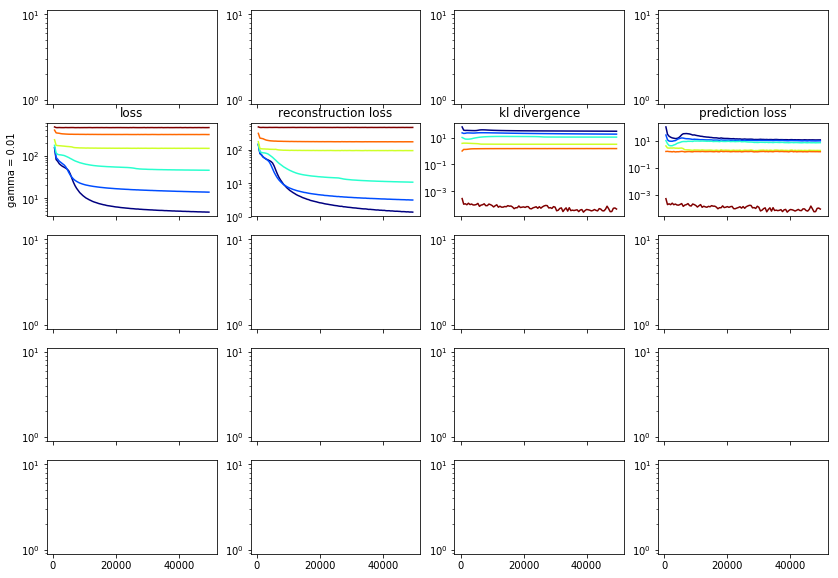

In [4]:
show_until_nth_batch = 200000
idx_lim = np.max(np.where(np.array(training_stats[lastone]['iter']) < show_until_nth_batch))

fig, ax = plt.subplots(ng,4,sharey=False,sharex=True, figsize=(14,10))
ax = ax.flatten()

col = plt.cm.jet(np.linspace(0,1,len(normalized_beta_values)))
for jj,gam in enumerate(gamma_values):
    for ii,_ in enumerate(normalized_beta_values):
        if training_stats[nb*jj+ii]:
            logged_steps = training_stats[nb*jj+ii]['iter'][:idx_lim]
            recon_loss = np.array(training_stats[nb*jj+ii]['recon_loss'][:idx_lim])
            total_kld = np.array(training_stats[nb*jj+ii]['total_kld'][:idx_lim])
            pred_loss = np.array(training_stats[nb*jj+ii]['pred_loss'][:idx_lim])

            ax[4*jj+0].plot(logged_steps, recon_loss+ beta[ii] * total_kld + gam*pred_loss, color=col[ii])
            ax[4*jj+1].plot(logged_steps, recon_loss, color=col[ii])
            ax[4*jj+2].plot(logged_steps, total_kld, color=col[ii])
            ax[4*jj+3].plot(logged_steps, pred_loss, color=col[ii])

            ax[4*jj+0].set(title='loss')
            ax[4*jj+1].set(title='reconstruction loss')
            ax[4*jj+2].set(title='kl divergence')
            ax[4*jj+3].set(title='prediction loss')

            _ = [x.set(yscale='log') for x in ax]

#             if jj<1:
#                 ax[2].legend(['betanorm = %0.3f / beta = %0.1f' % (x,y) for x,y in zip(normalized_beta_values,beta)], loc=1)
            ax[4*jj+0].set(ylabel=('gamma = %s' % gamma_values[jj]))

beta clearly modulates the trade-off between reconstruction and kl-divergence (as expected)


##### plotting reconstruction loss and kl-divergence for each beta value separately

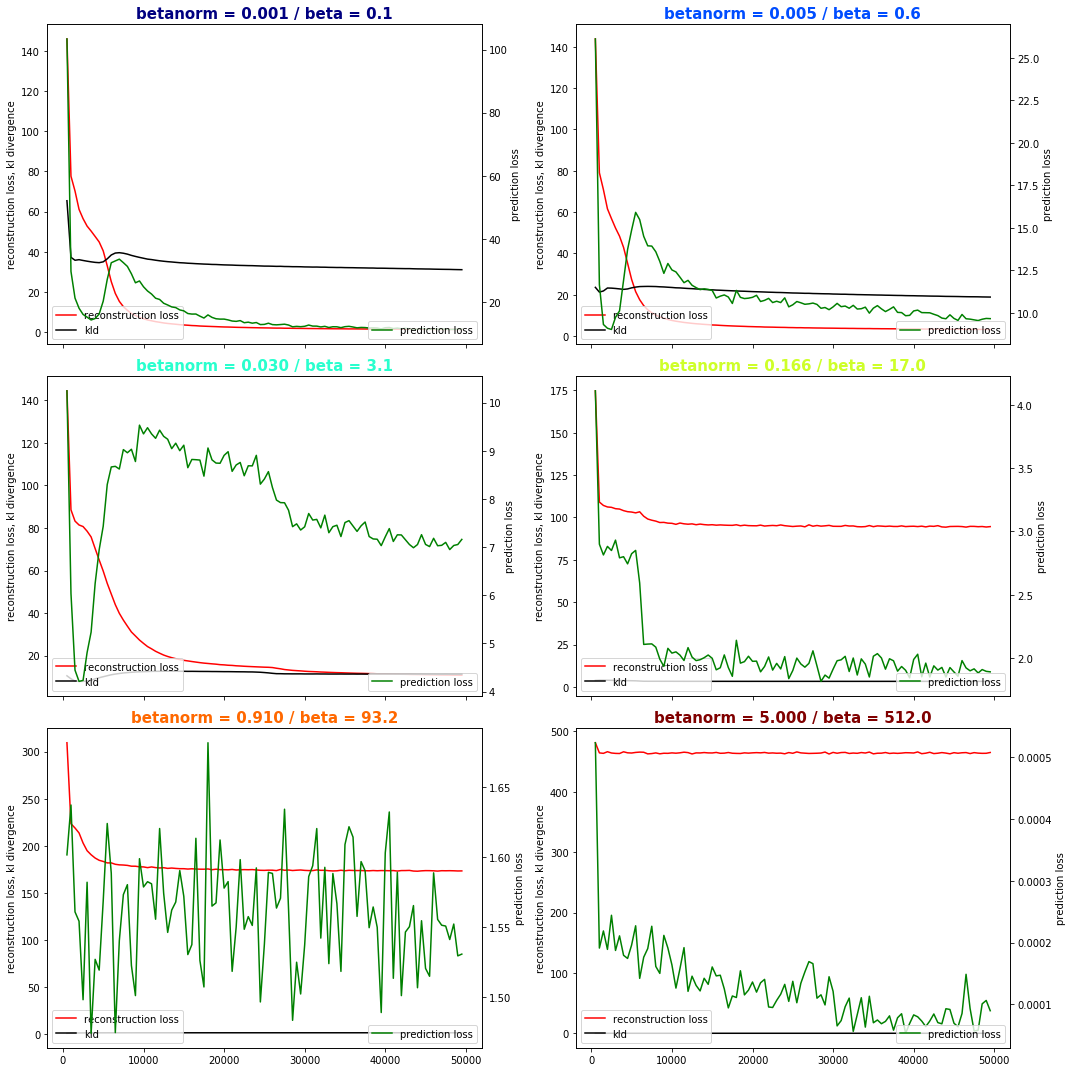

In [5]:
jj=1 # gamma = 0.01

fig, ax = plt.subplots(3,2,sharey=False,sharex=True, figsize=(15,15))
ax = ax.flatten()

col = plt.cm.jet(np.linspace(0,1,len(normalized_beta_values)))
ax2 = list()
for ii,_ in enumerate(normalized_beta_values):
    logged_steps = training_stats[nb*jj+ii]['iter'][:idx_lim]
    recon_loss = np.array(training_stats[nb*jj+ii]['recon_loss'][:idx_lim])
    total_kld = np.array(training_stats[nb*jj+ii]['total_kld'][:idx_lim])
    pred_loss = np.array(training_stats[nb*jj+ii]['pred_loss'][:idx_lim])
    
    ax[ii].plot(logged_steps, recon_loss, color='r', label='reconstruction loss')
    ax[ii].plot(logged_steps, total_kld, color='k', label='kld')
    ax2.append(ax[ii].twinx())
    
    ax2[ii].plot(logged_steps, pred_loss, color='g', label='prediction loss')
    
    ##ax[0].set(ylabel='loss')
    #ax[1].set(ylabel='reconstruction loss')    
    ax[ii].set(ylabel='reconstruction loss, kl divergence')
    ax2[ii].set(ylabel='prediction loss')
    plt.title('betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii]), color=col[ii], 
              fontweight='bold', fontsize = 15)
    
    ax[ii].legend(loc=3)
    ax2[ii].legend(loc=4)
    
fig.tight_layout()

some interesting training dynamics for the lowest beta (.001) -> kld increases first. then, after reconstruction loss convergeces (to almost zero), kld is reduced.

## load some data and plot reconstructions


In [6]:
ds = dSpriteBackgroundDatasetTime(transform=transforms.Resize(32),shapetype = 'circle')

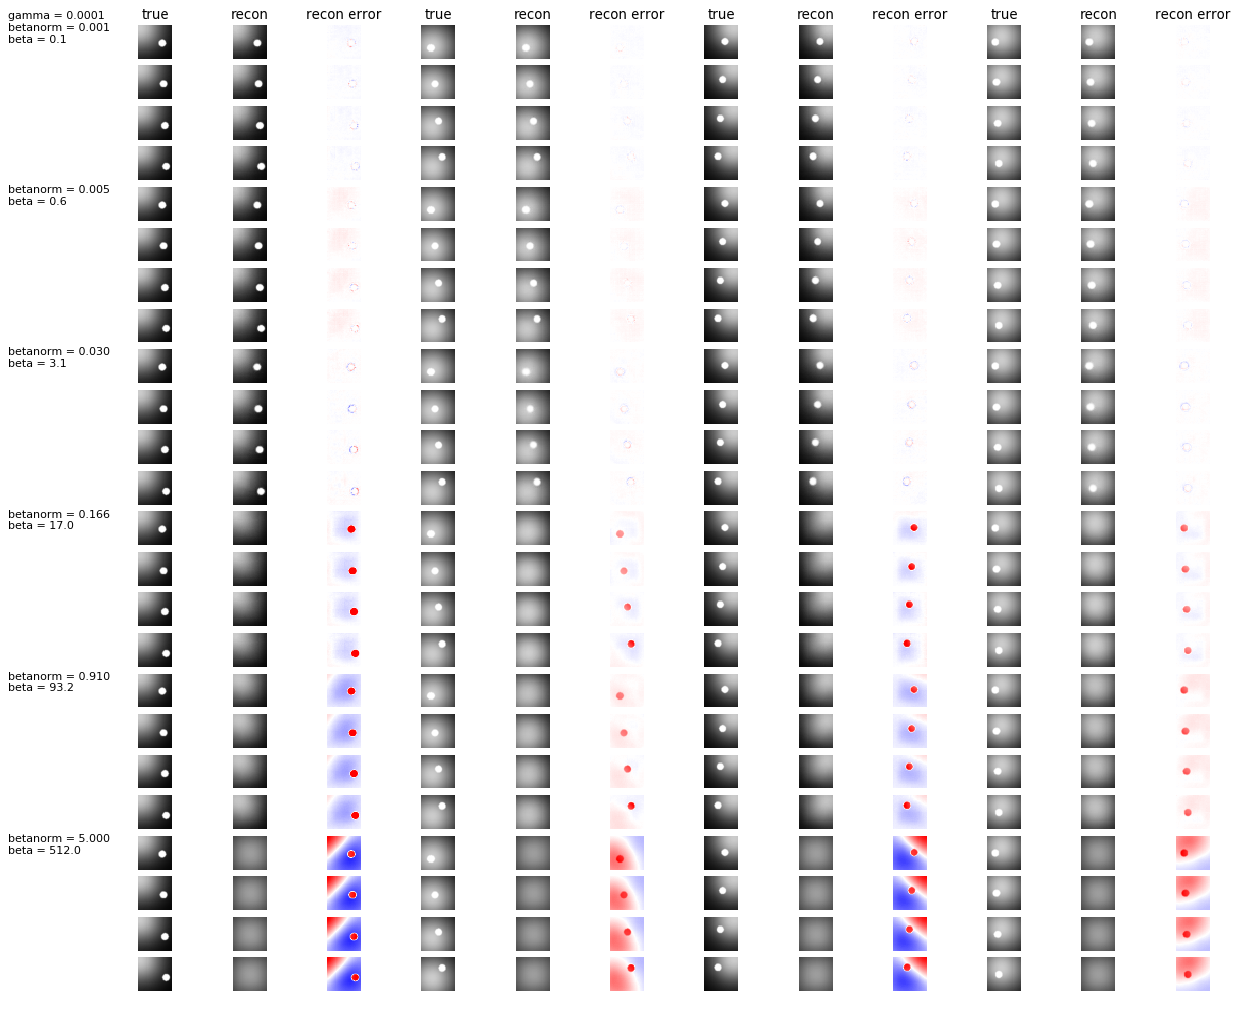

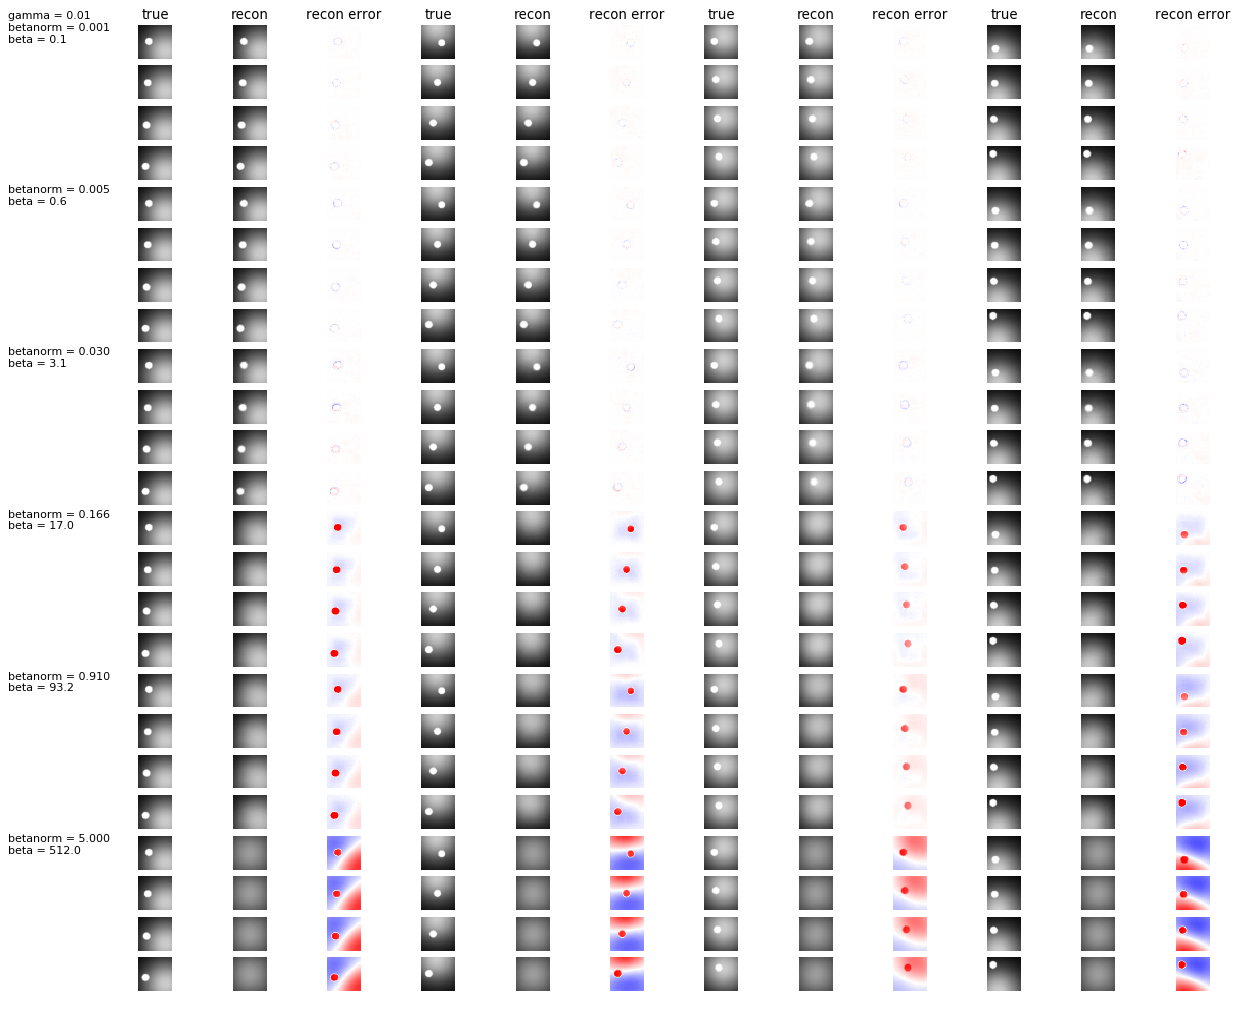

In [29]:
for gg,gam in enumerate(gamma_values): # loop across rows (different gamma values)

    if any(isTrained[(nb*gg+0):(nb*gg+nb)]):
        fig, ax = plt.subplots(nb*4,12,figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        ax = ax.flatten()
        m = .5
        img_idx = np.random.randint(1000, size=4)

        for jj,_ in enumerate(normalized_beta_values): # loop across rows (different beta values)
            if isTrained[nb*gg+jj]:
                for ii in range(4): # loop across different samples

                    x,label = ds[img_idx[ii]]
                    x = x[np.newaxis, :, :]

                    mu, logvar = vae[nb*gg+jj].encode(x.float())
                    recon = vae[nb*gg+jj].decode(mu).detach()
                    diff = x - recon

                    for ff in range(1,5):
                        axnum = jj*12*4+(ff-1)*12+ii*3
                        plt.set_cmap('gray')
                        ax[axnum+0].imshow(x[:,ff*2,:,:,:].squeeze(), vmin=0, vmax=1)
                        ax[axnum+0].axis('off')

                        ax[axnum+1].imshow(recon[:,ff*2,:,:,:].squeeze(), vmin=0, vmax=1)
                        ax[axnum+1].axis('off')

                        plt.set_cmap('bwr')
                        img = ax[axnum+2].imshow(diff[:,ff*2,:,:,:].numpy().squeeze(), vmin=-m, vmax=m)
                        ax[axnum+2].axis('off')

                pos = ax[jj*12*4].get_position()
                if jj==0:
                    fig.text(.05, pos.y0 + pos.height/2, 'gamma = %s\nbetanorm = %0.3f\nbeta = %0.1f' % (gam,normalized_beta_values[jj],beta[jj]))
                else:
                    fig.text(.05, pos.y0 + pos.height/2, 'betanorm = %0.3f\nbeta = %0.1f' % (normalized_beta_values[jj],beta[jj]))

        for ii in range(4):
            ax[ii*3+0].set(title='true')
            ax[ii*3+1].set(title='recon')
            ax[ii*3+2].set(title='recon error')
    

Each row displays the true/reconstructed/error for four samples with one beta.

- Interestingly, with increased beta, the circle object gets lost / is not captured by the VAE any more. 

- At very high beta values, the gaussian background blob is always reconstructed at the same (central) location. This is the case, when q(z|x) is almost equal to p(z), hence indepndent of x. The best "reconstruction" (to minimize reconstruction loss) is the mean image. -> probably, what we see in the high-beta reconstruction case is therefore not a central Gaussian but the average of all circle positions. As circles are constrained to not touch the image borders, this mean image looks like a centered Gaussian.